In [1]:
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
from utils import *

DEVICE:  cpu


In [3]:
T=30

In [4]:
etfs = ['XLB','XLE','XLF','XLI','XLP','XLV','XLY','XLU']
metrics = ["ATR","Squared_Returns"]
start = '2001-01-01'
end = '2020-01-01'
start_t = '2022-01-02'
end_t = '2024-01-05'
models = {}
lrs = [0]
hl1 = 50
hl2 = 50

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 30th day, Bought 6.014022518694977 shares for $499.404429952431
On the 42th day, Bought 2.5058957513695326 shares for $209.4928848144929
On the 43th day, Bought 1.5025871679983909 shares for $125.75152008978533
On the 44th day, Bought 0.5007457410116898 shares for $42.6435073045555
On the 45th day, Bought 0.5006880639191931 shares for $43.124262945360094
On the 46th day, Bought 0.0 shares for $0.0
On the 47th day, Bought 0.0 shares for $0.0
On the 48th day, Bought 0.0 shares for $0.0
On the 49th day, Bought 0.0 shares for $0.0
On the 50th day, Bought 0.0 shares for $0.0
On the 51th day, Bought 0.0 shares for $0.0
On the 52th day, Bought 0.0 shares for $0.0
On the 53th day, Bought 0.0 shares for $0.0
On the 54th day, Bought 0.0 shares for $0.0
On the 55th day, Bought 0.0 shares for $0.0
On the 56th day, Bought 0.0 shares for $0.0
On the 57th day, Bought 0.0 shares for $0.0
On the 58th day, Bought 0.0 shares for $0.0
On the 59th day, Bough

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLB
On the 64th day, Bought 5.500000488037849 shares for $489.5000434353686
On the 70th day, sold 5.500000488037849 shares for $462.9900410830262
On the 148th day, Bought 6.0000007529282335 shares for $483.6600606935449
On the 161th day, sold 6.0000007529282335 shares for $444.7200558070407
On the 218th day, Bought 5.5000006854685815 shares for $452.5400564003549
On the 225th day, Bought 2.5000002811761557 shares for $205.3750230986212
On the 232th day, Bought 1.5000001982844533 shares for $120.79501596784702
On the 253th day, Bought 0.5000000451778195 shares for $41.855003781835265
On the 260th day, Bought 0.5000000787031067 shares for $41.55000654022816
On the 267th day, Bought 0.0 shares for $0.0
On the 274th day, Bought 0.0 shares for $0.0
On the 281th day, Bought 0.0 shares for $0.0
On the 288th day, Bought 0.0 shares for $0.0
On the 294th day, sold 10.500001288810116 shares for $792.8550973180519
On the 309th day, Bought 5.000000432158657 sha

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 288th day, Bought 5.51479575120147 shares for $470.90840919509355
On the 294th day, sold 5.51479575120147 shares for $424.47382896997715
On the 306th day, Bought 5.011771364297877 shares for $435.22222527562764
On the 315th day, Bought 3.005626288764174 shares for $258.48386083371895
On the 316th day, Bought 1.5038457896247643 shares for $128.9698149182198
On the 317th day, Bought 0.5012302963947985 shares for $42.62462440541367
On the 318th day, Bought 0.5009446805255944 shares for $42.976044142290746
On the 319th day, Bought 0.0 shares for $0.0
On the 320th day, Bought 0.0 shares for $0.0
On the 321th day, Bought 0.0 shares for $0.0
On the 322th day, Bought 0.0 shares for $0.0
On the 323th day, Bought 0.0 shares for $0.0
On the 324th day, Bought 0.0 shares for $0.0
On the 340th day, Bought 0.0 shares for $0.0
On the 341th day, Bought 0.0 shares for $0.0
On the 342th day, Bought 0.0 shares for $0.0
On the 343th day, Bought 0.0 shares fo

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLE


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLE
On the 65th day, Bought 6.000003186589154 shares for $483.60025683908583
On the 66th day, Bought 3.000001357688263 shares for $241.71010938894335
On the 67th day, Bought 1.5000006430410693 shares for $121.72505218278278
On the 68th day, Bought 0.5000001969787486 shares for $38.900015324946644
On the 74th day, sold 11.000005384297234 shares for $839.8504110910937
On the 220th day, Bought 5.000002042091417 shares for $451.7001844825386
On the 223th day, Bought 2.5000010779424664 shares for $225.5500972519693
On the 224th day, Bought 1.500000448742703 shares for $136.8000409253345
On the 225th day, Bought 0.5000001180682612 shares for $43.540010281384184
On the 294th day, sold 9.500003686844847 shares for $731.2152837764479
XLE Final Value: 827.5399281905563, Final Money: 827.5399281905563, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLF
On the 51th day, Bought 12.508910254534369 shares for $498.980430053376
On the 52th day, Bought 6.005072639512928 shares for $237.20036926076065
On the 53th day, Bought 3.001767701833127 shares for $117.57924088080358
On the 54th day, Bought 1.5014903793208183 shares for $57.927498834197166
On the 55th day, Bought 1.0009682906617692 shares for $38.16692092293326
On the 56th day, Bought 0.5004265769015965 shares for $18.966167264570508
On the 143th day, Bought 0.0 shares for $0.0
On the 144th day, Bought 0.0 shares for $0.0
On the 145th day, Bought 0.0 shares for $0.0
On the 196th day, sold 24.518635842764606 shares for $809.3601691696596
On the 218th day, Bought 11.509674576048955 shares for $414.6935749750439
On the 219th day, Bought 5.50285669015261 shares for $197.60758374338022
On the 220th day, Bought 3.0014416813170737 shares for $106.40110760269027
On the 221th day, Bought 1.5010099029811181 shares for $53.51100304127686
On the 222th day

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLF


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLF
On the 267th day, Bought 13.500000694019077 shares for $490.72502522759345
On the 268th day, Bought 6.5000005781738786 shares for $238.74502123632655
On the 275th day, Bought 3.5000003405712095 shares for $126.70001232867779
On the 290th day, sold 23.500001612764162 shares for $743.3050510117305
On the 484th day, Bought 11.500000729909633 shares for $429.5250272621248
On the 485th day, Bought 6.0000003628373575 shares for $223.62001352294834
On the 486th day, Bought 3.0000002366486056 shares for $112.41000886722325
On the 487th day, Bought 1.5000000844069468 shares for $55.59000312812145
On the 491th day, Bought 0.5000000263766848 shares for $18.775000990444514
On the 492th day, Bought 0.5000000273122911 shares for $18.855001029946497
On the 493th day, Bought 0.0 shares for $0.0
On the 494th day, Bought 0.0 shares for $0.0
On the 495th day, Bought 0.0 shares for $0.0
XLF Final Value: 892.9299925813302, Final Money: 28.35993741832389, Final Shar

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLI
On the 39th day, Bought 5.0091431924899075 shares for $497.4079190142478
On the 40th day, Bought 2.506394347493509 shares for $246.95503505853543
On the 41th day, Bought 1.0030483476860228 shares for $99.47230464002288
On the 42th day, Bought 0.5008757714057548 shares for $50.31797999542212
On the 43th day, Bought 0.5008416910798235 shares for $50.334589953522254
On the 44th day, Bought 0.0 shares for $0.0
On the 45th day, Bought 0.0 shares for $0.0
On the 46th day, Bought 0.0 shares for $0.0
On the 47th day, Bought 0.0 shares for $0.0
On the 48th day, Bought 0.0 shares for $0.0
On the 49th day, Bought 0.0 shares for $0.0
On the 50th day, Bought 0.0 shares for $0.0
On the 51th day, Bought 0.0 shares for $0.0
On the 52th day, Bought 0.0 shares for $0.0
On the 53th day, Bought 0.0 shares for $0.0
On the 54th day, Bought 0.0 shares for $0.0
On the 55th day, Bought 0.0 shares for $0.0
On the 56th day, Bought 0.0 shares for $0.0
On the 57th day, Bou

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLI


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLI
XLI Final Value: 1000.0, Final Money: 1000, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLP
On the 48th day, Bought 6.511027570019519 shares for $483.1182456954483
On the 50th day, Bought 3.002895544972972 shares for $225.427368561121
On the 51th day, Bought 1.501343571595947 shares for $114.01203082699621
On the 52th day, Bought 1.0012516500079116 shares for $75.81477493859907
On the 53th day, Bought 0.5006515932201581 shares for $38.03950805286761
On the 54th day, Bought 0.0 shares for $0.0
On the 55th day, Bought 0.0 shares for $0.0
On the 56th day, Bought 0.0 shares for $0.0
On the 57th day, Bought 0.0 shares for $0.0
On the 76th day, sold 12.517169929816507 shares for $977.8413149172657
On the 156th day, Bought 7.006429806959161 shares for $518.5458700130475
On the 219th day, Bought 3.0035324969782526 shares for $228.17836379543786
On the 220th day, Bought 1.5010736411310601 shares for $113.72133905208912
On the 221th day, Bought 1.0008879817805976 shares for $75.68714918224879
On the 222th day, Bought 0.5002777820605219 shares f

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLP


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLP
On the 61th day, Bought 6.000000575930281 shares for $470.46004515869333
On the 62th day, Bought 3.0000002370117382 shares for $235.0800185722398
On the 63th day, Bought 1.5000001625980075 shares for $118.4850128436166
On the 69th day, Bought 1.000000098108937 shares for $79.4900077986794
On the 75th day, sold 11.500001073648964 shares for $878.6000820267809
XLP Final Value: 975.0849976535518, Final Money: 975.0849976535518, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLV
On the 46th day, Bought 3.507397485091765 shares for $479.11049646353507
On the 47th day, Bought 1.505051883278447 shares for $204.44624782454423
On the 48th day, Bought 1.002341953005756 shares for $134.8550863573944
On the 49th day, Bought 0.5010722896741162 shares for $68.19593862464721
On the 50th day, Bought 0.0 shares for $0.0
On the 51th day, Bought 0.0 shares for $0.0
On the 52th day, Bought 0.0 shares for $0.0
On the 53th day, Bought 0.0 shares for $0.0
On the 54th day, Bought 0.0 shares for $0.0
On the 55th day, Bought 0.0 shares for $0.0
On the 56th day, Bought 0.0 shares for $0.0
On the 57th day, Bought 0.0 shares for $0.0
On the 58th day, Bought 0.0 shares for $0.0
On the 59th day, Bought 0.0 shares for $0.0
On the 74th day, sold 6.515863611050085 shares for $843.6740203587649
On the 126th day, Bought 3.5079204026187165 shares for $457.1872660732974
On the 134th day, Bought 1.5039640540168515 shares for $198.77892901940726
On the 1

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLV


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLV
On the 109th day, Bought 4.000000893357271 shares for $487.2801088287827
On the 110th day, sold 4.000000893357271 shares for $508.36011353677554
On the 270th day, Bought 3.500000770673375 shares for $460.00510128960167
On the 284th day, Bought 2.0000003020789414 shares for $256.6600387657906
On the 402th day, Bought 1.000000270750102 shares for $133.4700361370161
On the 404th day, Bought 0.5000001104186861 shares for $66.67001472322761
On the 415th day, Bought 0.0 shares for $0.0
On the 416th day, Bought 0.0 shares for $0.0
On the 426th day, Bought 0.0 shares for $0.0
On the 430th day, Bought 0.0 shares for $0.0
On the 451th day, sold 7.000001453921104 shares for $871.7801810713344
XLV Final Value: 976.0549948636913, Final Money: 976.0549948636913, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLY
On the 30th day, Bought 2.50750671953944 shares for $437.4596222908507
On the 31th day, Bought 1.5060047572722242 shares for $266.8188628459199
On the 32th day, Bought 0.50224819584602 shares for $88.07926610551652
On the 33th day, Bought 0.5018627363525178 shares for $89.99402588273348
On the 34th day, Bought 0.0 shares for $0.0
On the 35th day, Bought 0.0 shares for $0.0
On the 36th day, Bought 0.0 shares for $0.0
On the 37th day, Bought 0.0 shares for $0.0
On the 38th day, Bought 0.0 shares for $0.0
On the 39th day, Bought 0.0 shares for $0.0
On the 40th day, Bought 0.0 shares for $0.0
On the 41th day, Bought 0.0 shares for $0.0
On the 42th day, Bought 0.0 shares for $0.0
On the 43th day, Bought 0.0 shares for $0.0
On the 44th day, Bought 0.0 shares for $0.0
On the 45th day, Bought 0.0 shares for $0.0
On the 46th day, Bought 0.0 shares for $0.0
On the 47th day, Bought 0.0 shares for $0.0
On the 48th day, Bought 0.0 shares for $0.0
On the 49t

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLY


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLY
On the 69th day, Bought 2.50000030311617 shares for $435.7000528270861
On the 72th day, sold 2.50000030311617 shares for $429.00005201473476
XLY Final Value: 993.2999991876486, Final Money: 993.2999991876486, Final Shares: 0.0


[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLU
On the 45th day, Bought 7.006580573140438 shares for $493.54353557201244
On the 46th day, Bought 3.504513197007988 shares for $249.10079804332779
On the 47th day, Bought 1.5016736654811615 shares for $106.3785624626855
On the 48th day, Bought 1.0011217690642378 shares for $71.23982508661116
On the 49th day, Bought 0.5005462415944694 shares for $36.0393293948018
On the 50th day, Bought 0.0 shares for $0.0
On the 51th day, Bought 0.0 shares for $0.0
On the 52th day, Bought 0.0 shares for $0.0
On the 53th day, Bought 0.0 shares for $0.0
On the 54th day, Bought 0.0 shares for $0.0
On the 55th day, Bought 0.0 shares for $0.0
On the 56th day, Bought 0.0 shares for $0.0
On the 75th day, sold 13.514435446288294 shares for $956.8220295972112
On the 151th day, Bought 6.005236948977021 shares for $464.38497326439307
On the 152th day, Bought 3.503839008846927 shares for $268.0436841767899
On the 154th day, Bought 1.5011714690579063 shares for $114.98973452

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLU


[*********************100%***********************]  1 of 1 completed


read  504  lines of data for ticker:  XLU
On the 65th day, Bought 0.0 shares for $0.0
On the 94th day, Bought 6.500000005059135 shares for $485.35500037776563
On the 100th day, Bought 3.0000000021713467 shares for $224.40000016241672
On the 103th day, sold 9.500000007230483 shares for $646.5700004921067
On the 150th day, Bought 0.0 shares for $0.0
XLU Final Value: 936.8149999519243, Final Money: 936.8149999519243, Final Shares: 0.0


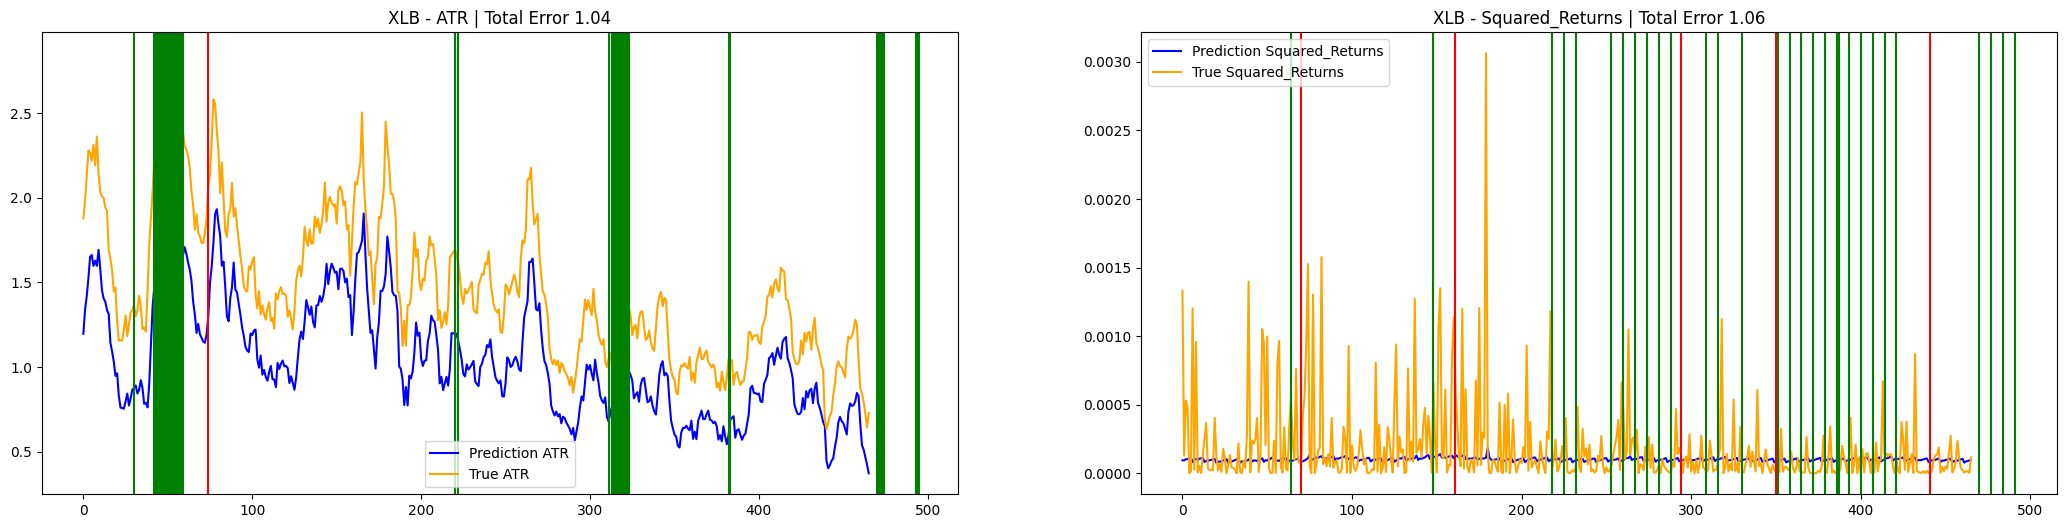

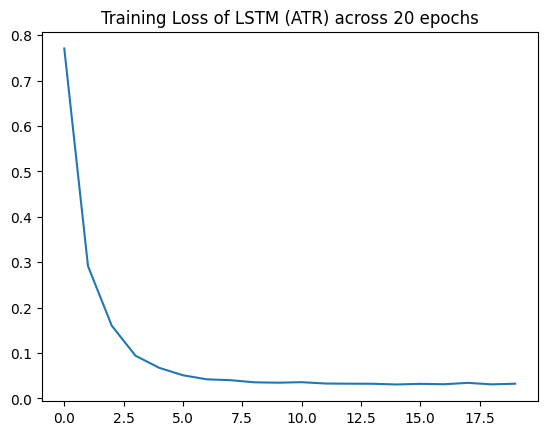

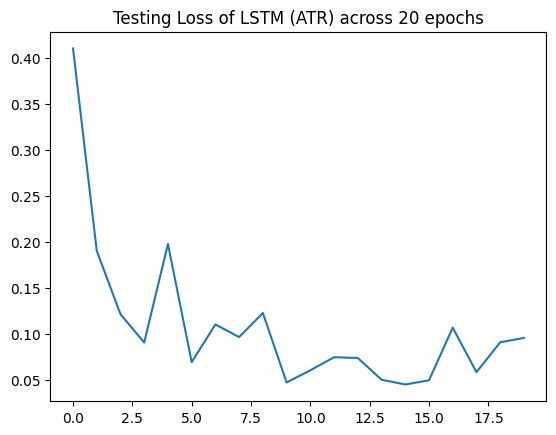

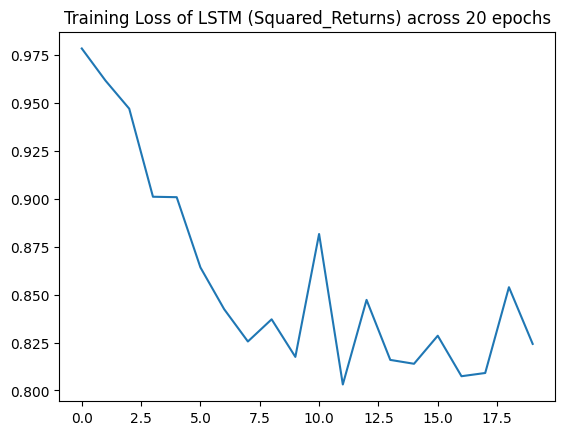

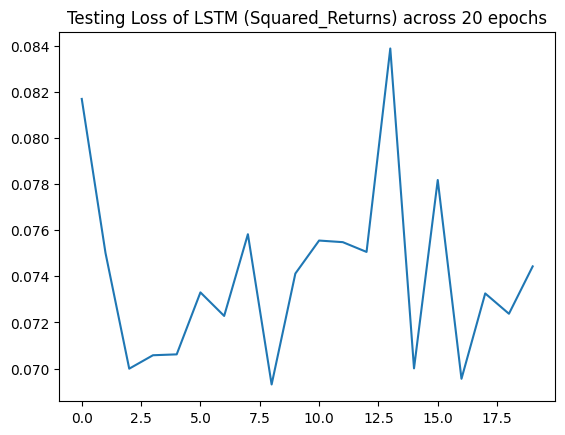

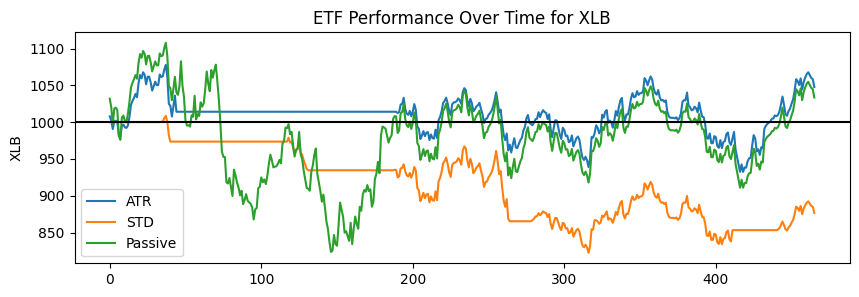

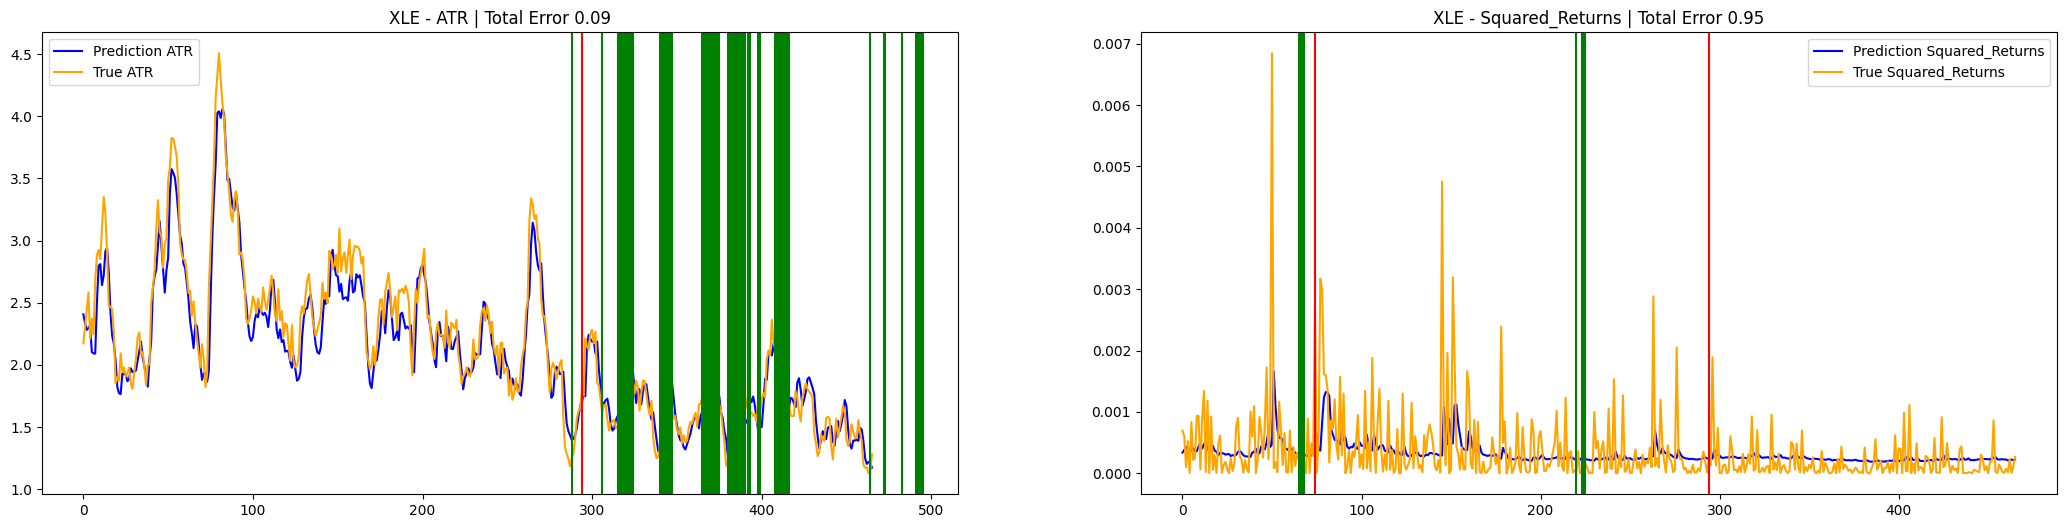

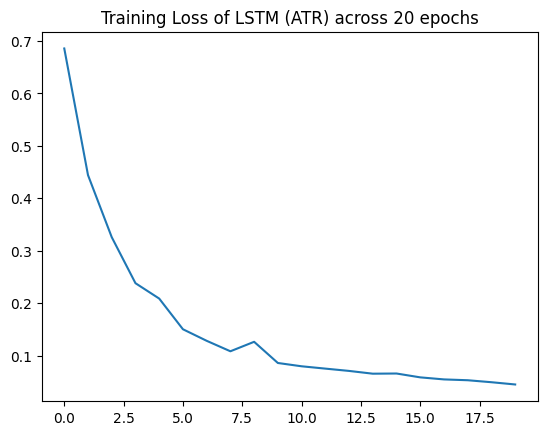

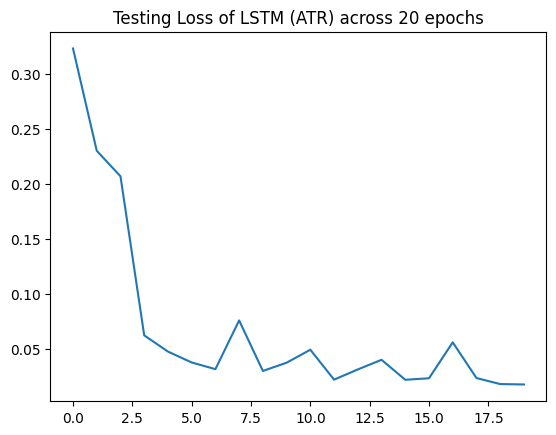

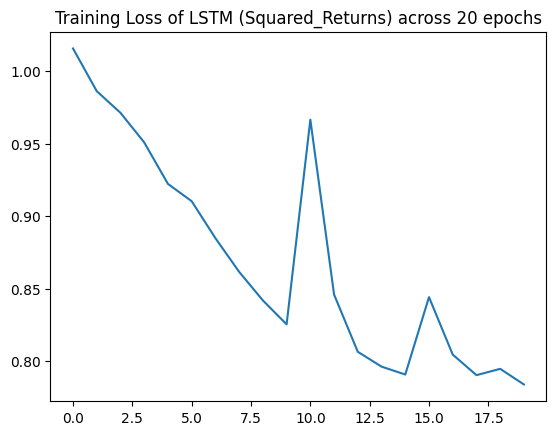

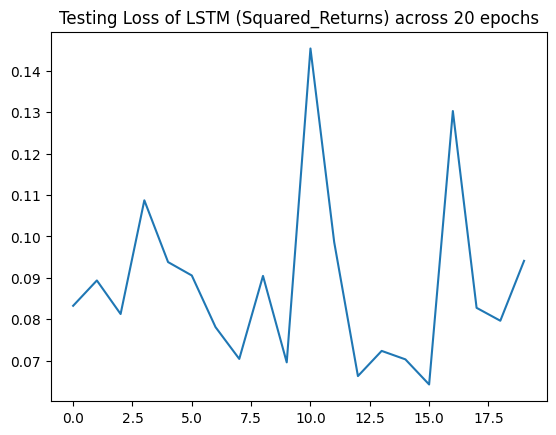

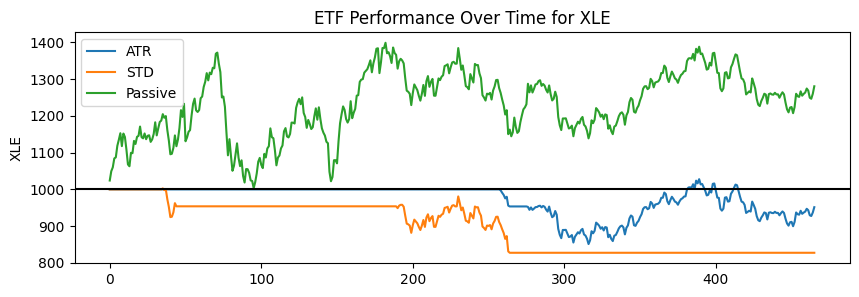

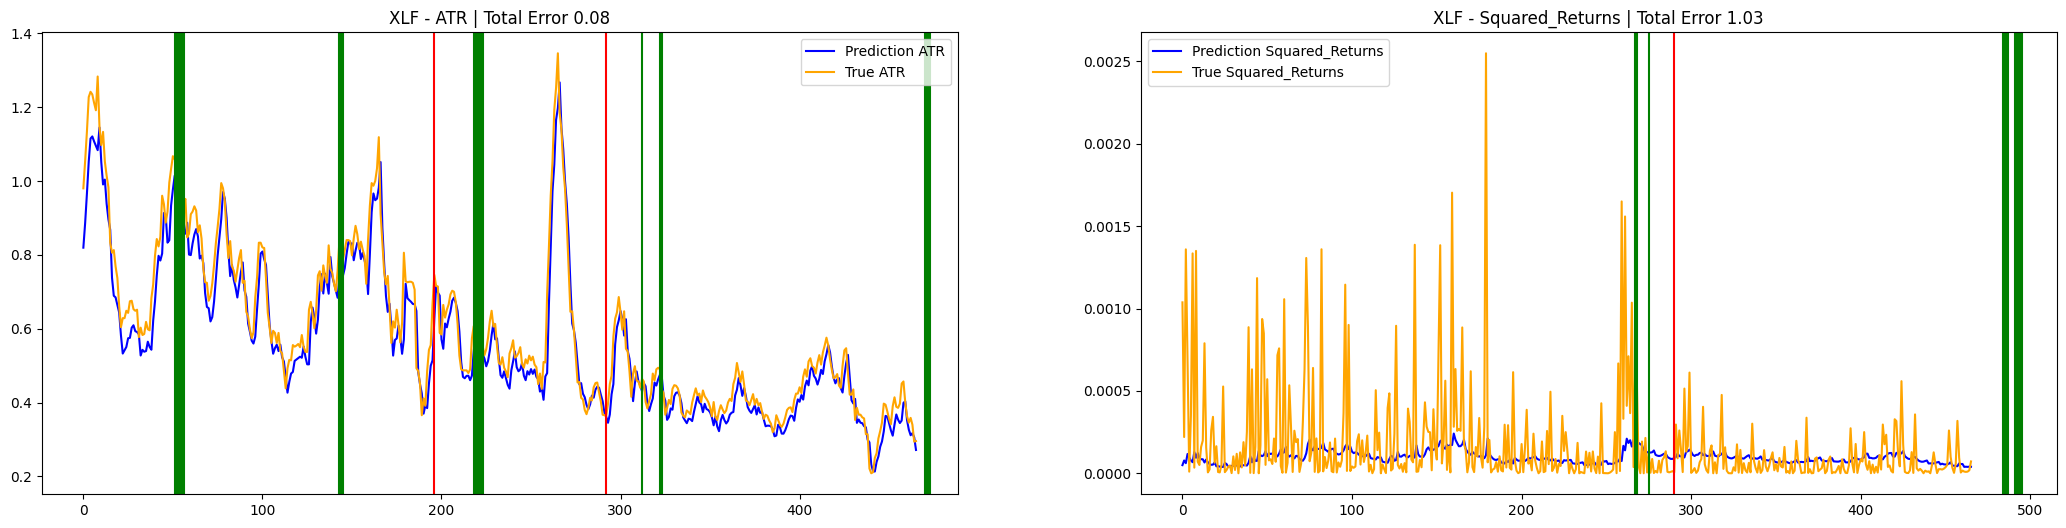

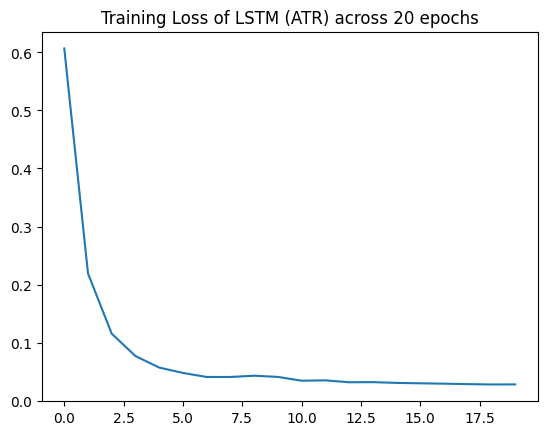

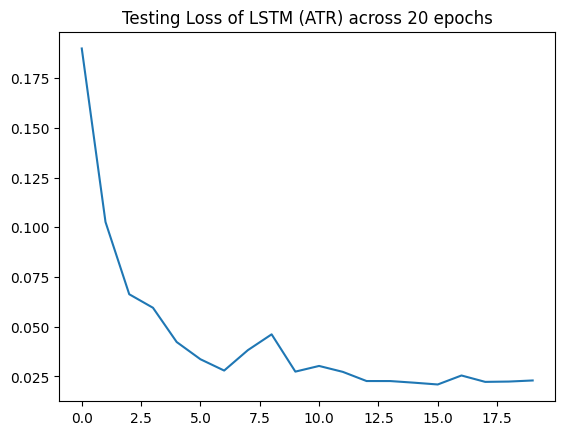

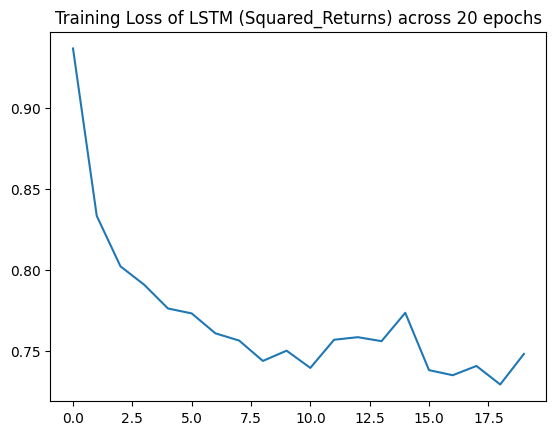

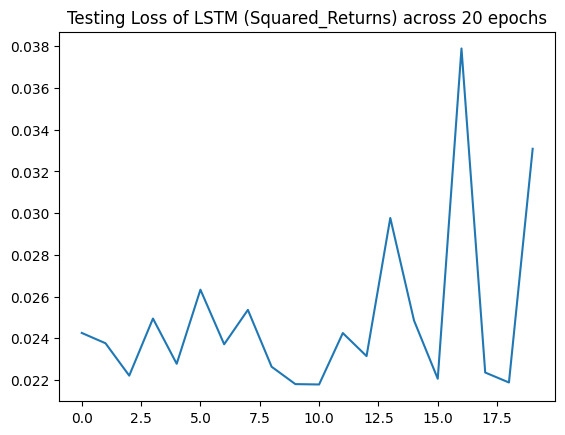

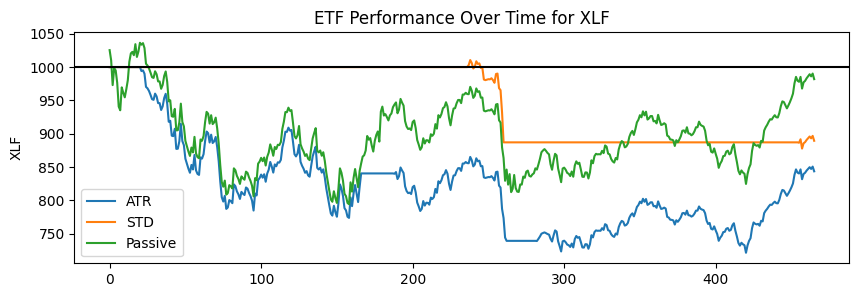

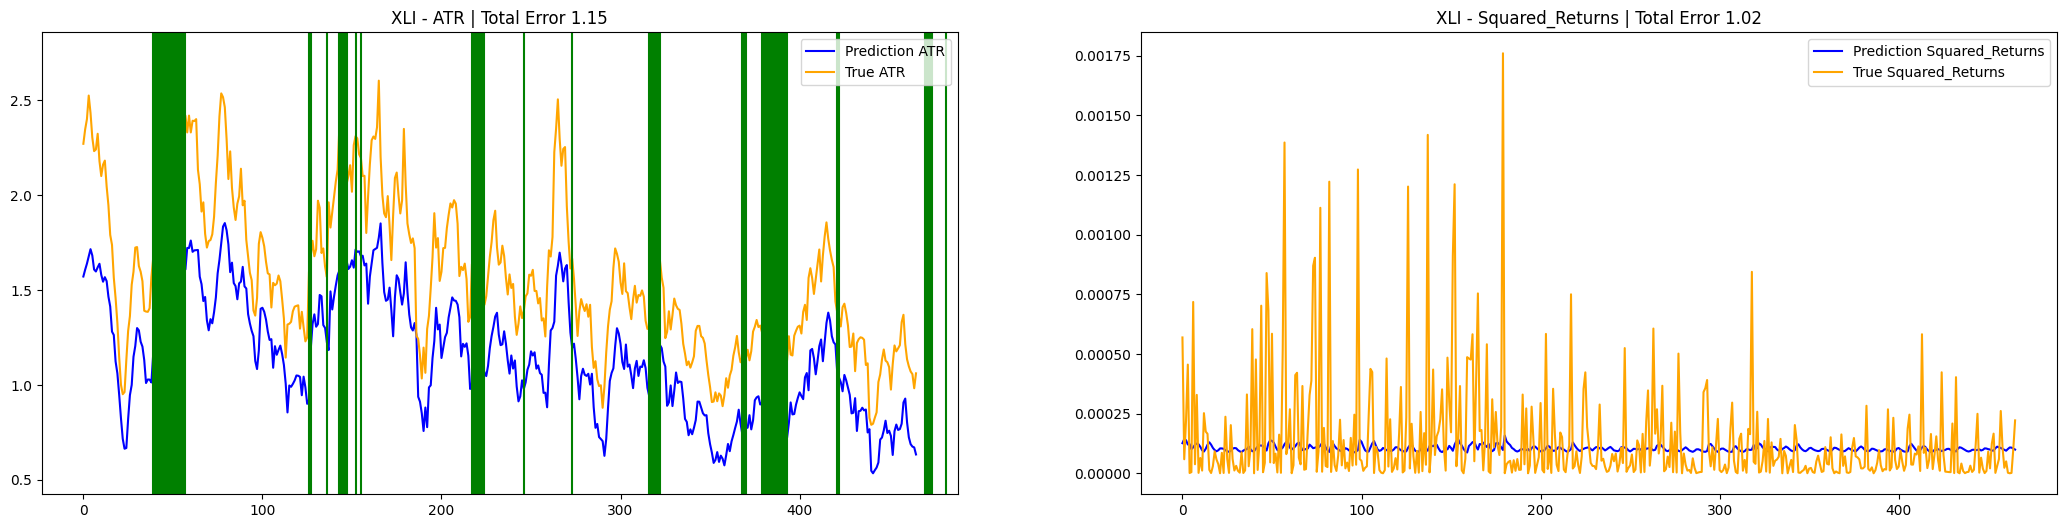

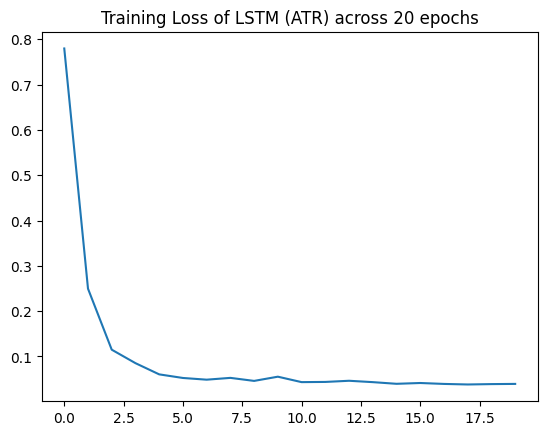

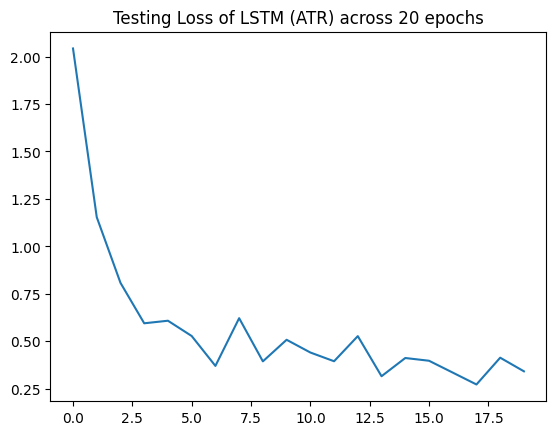

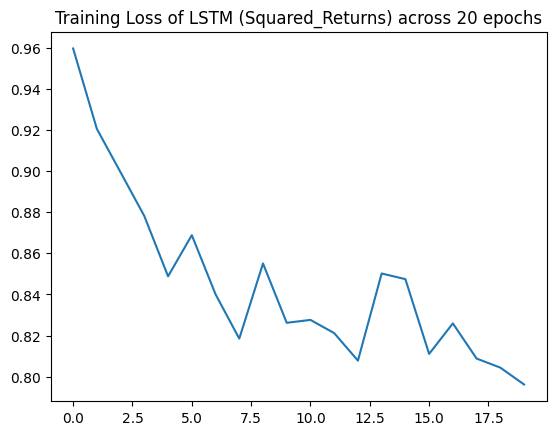

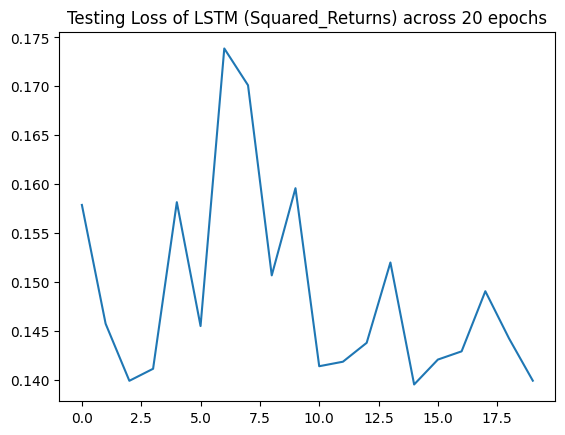

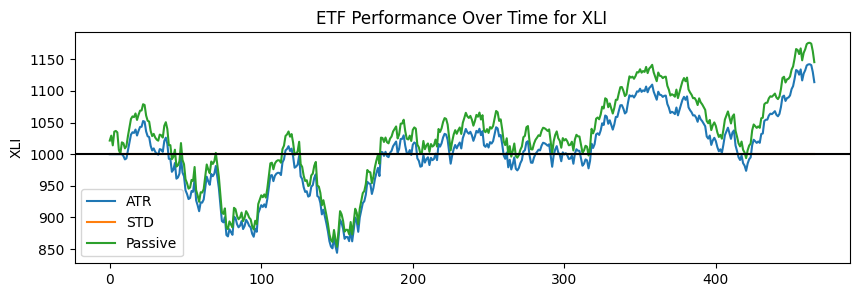

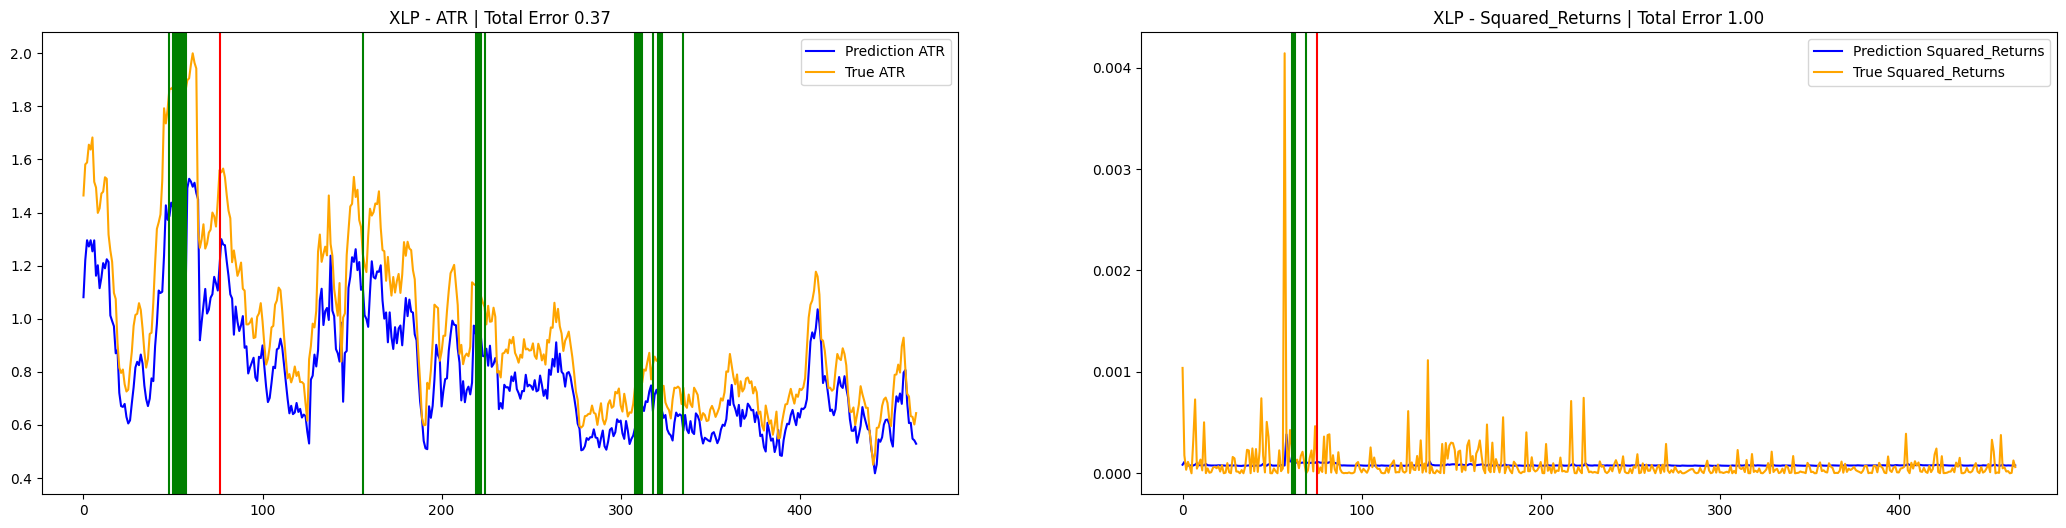

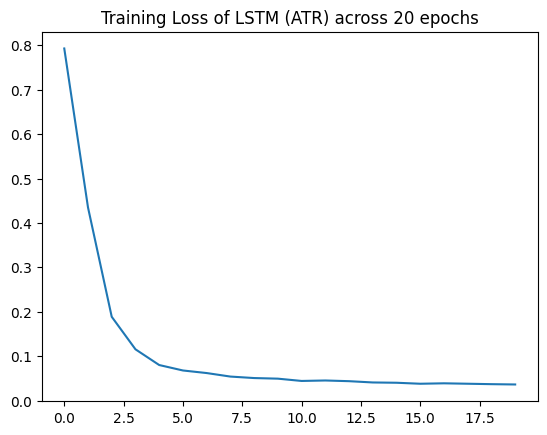

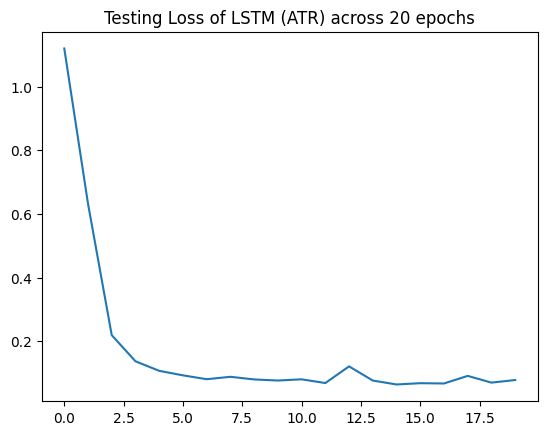

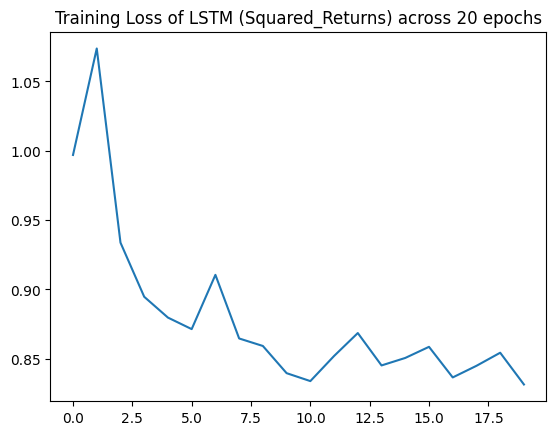

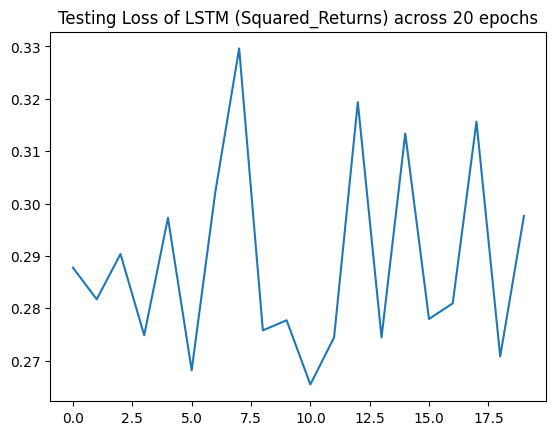

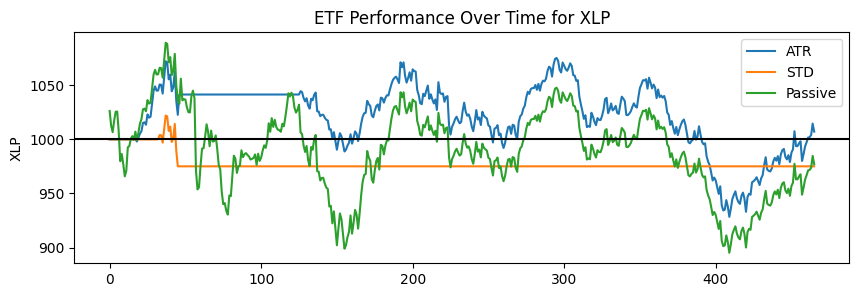

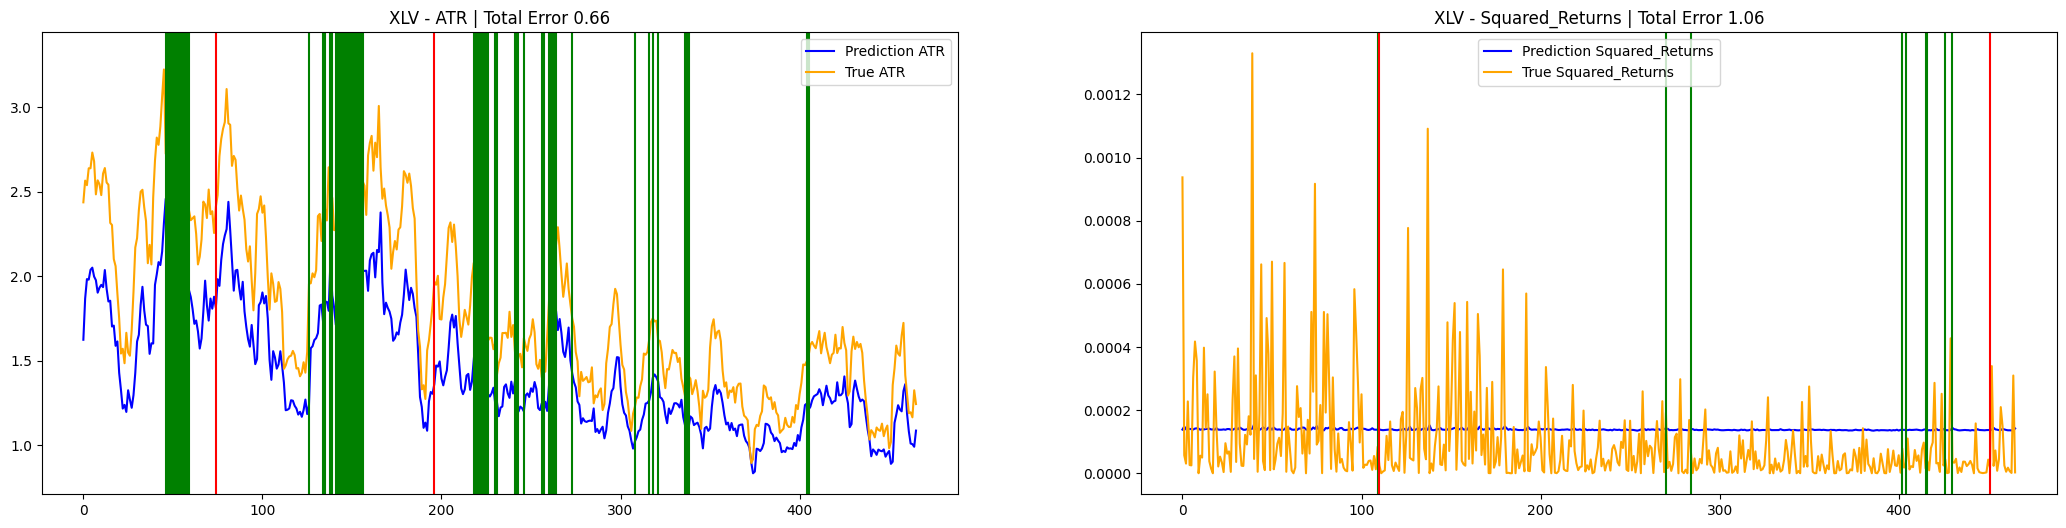

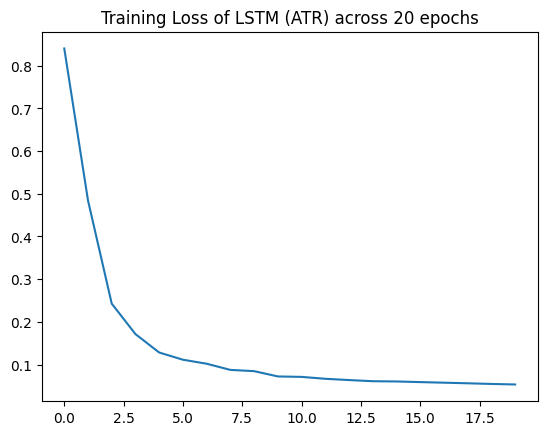

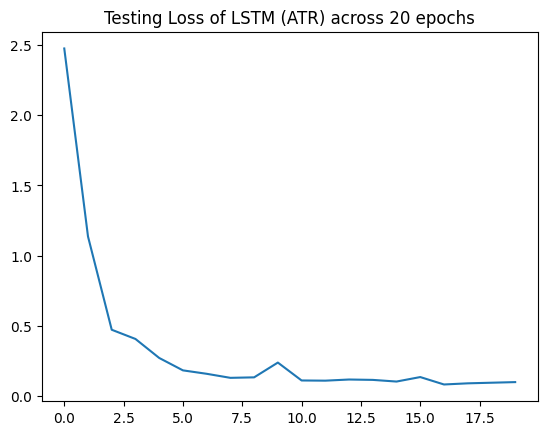

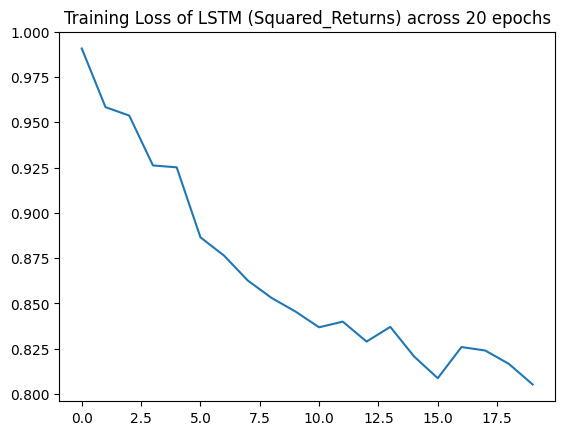

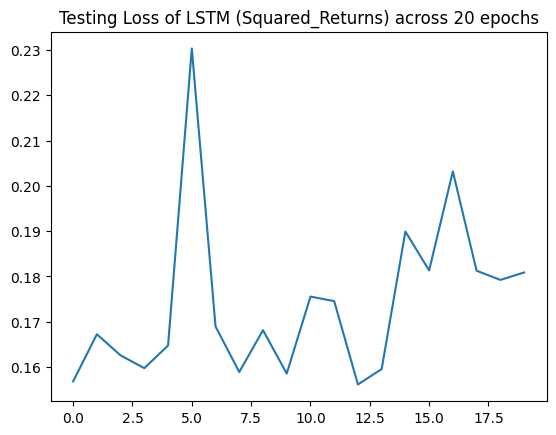

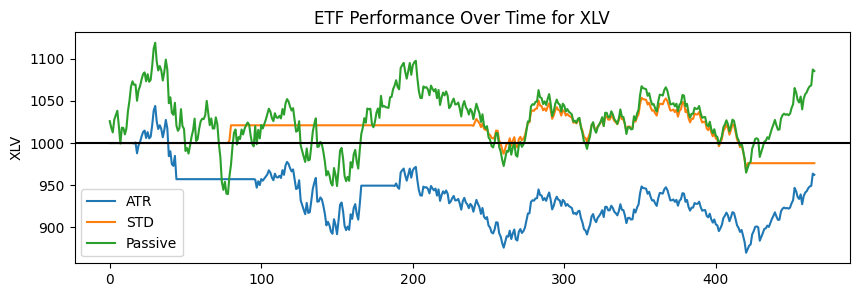

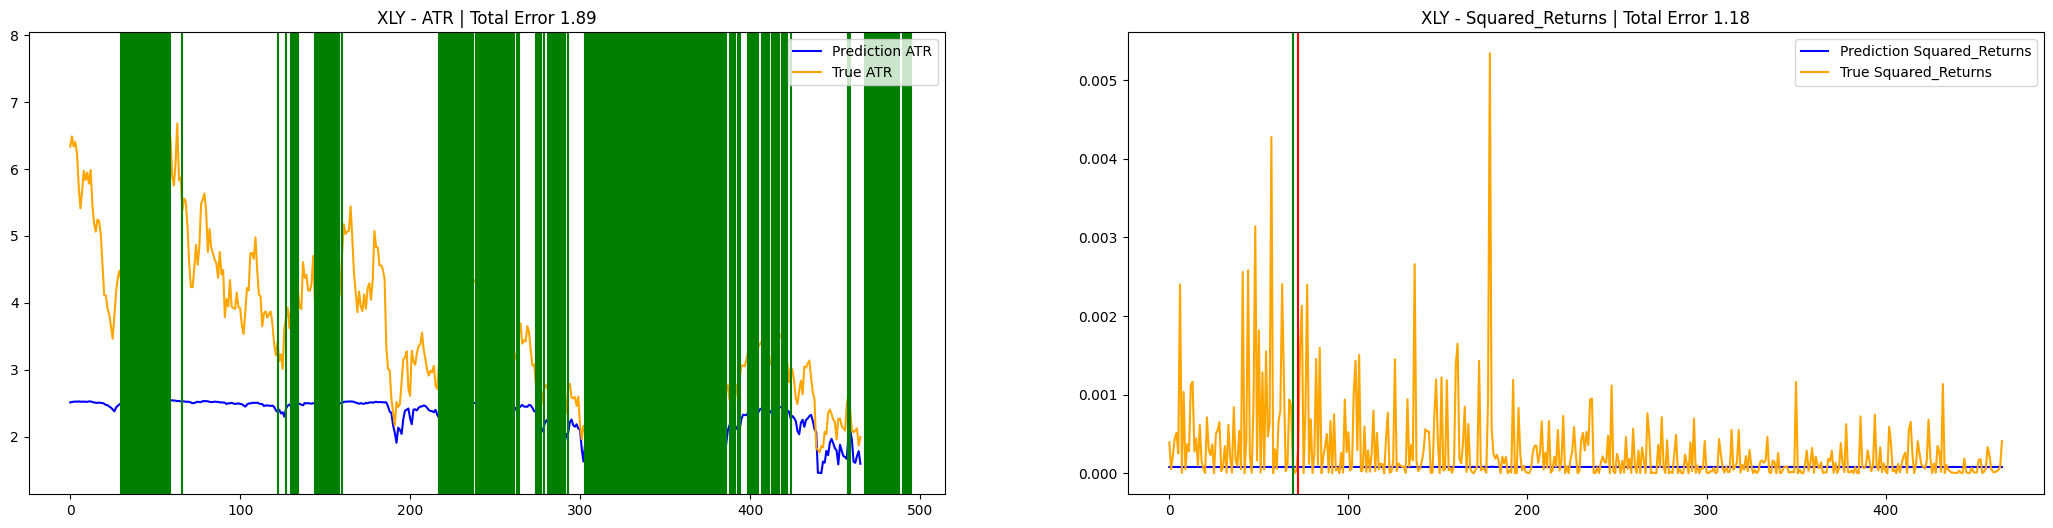

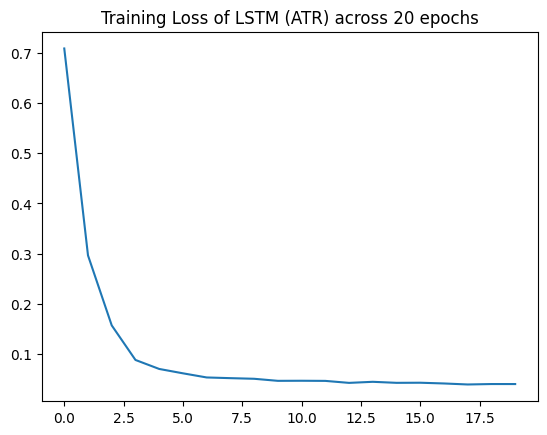

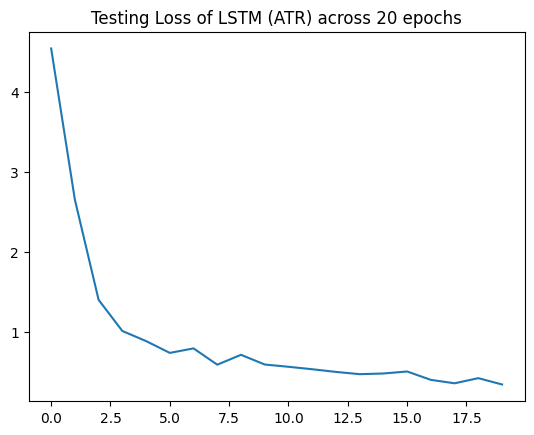

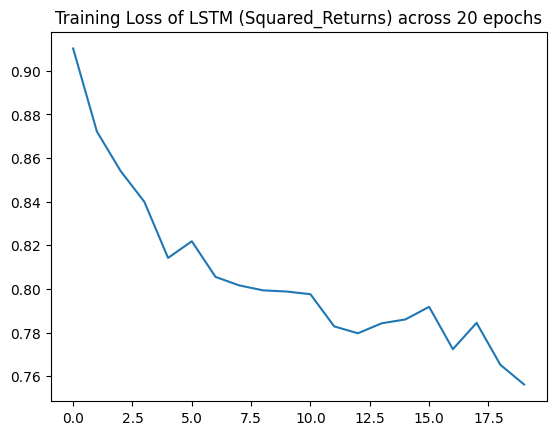

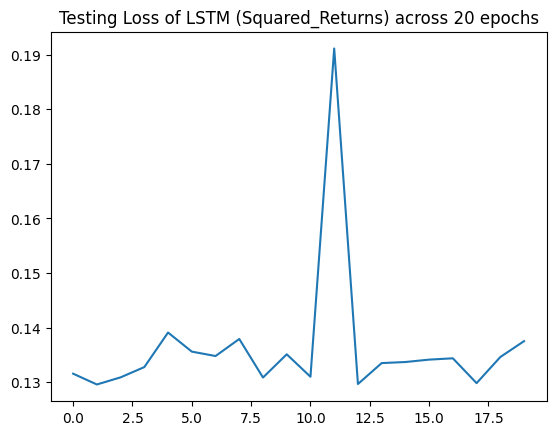

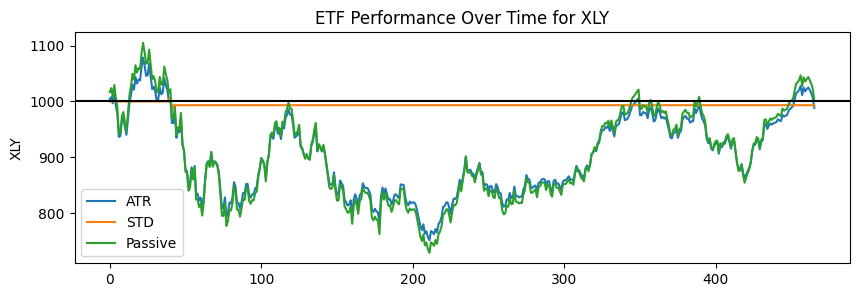

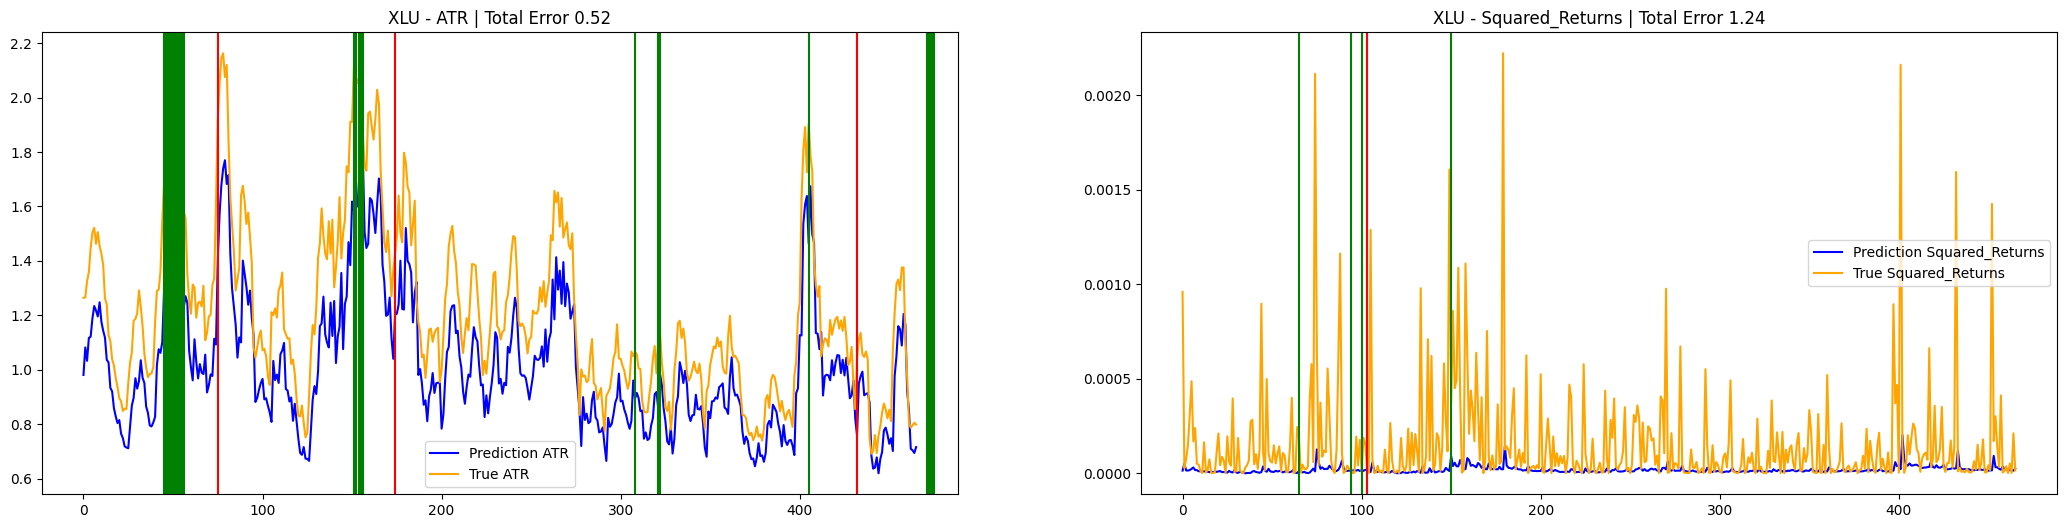

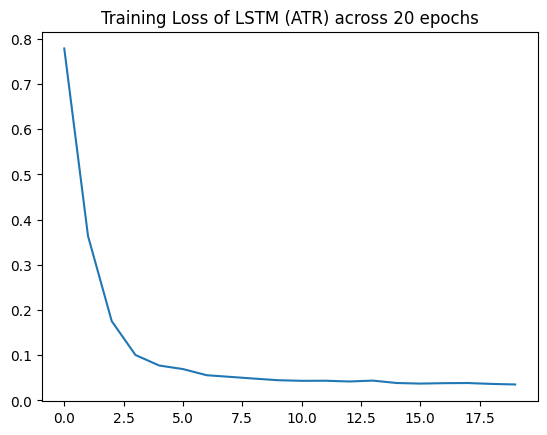

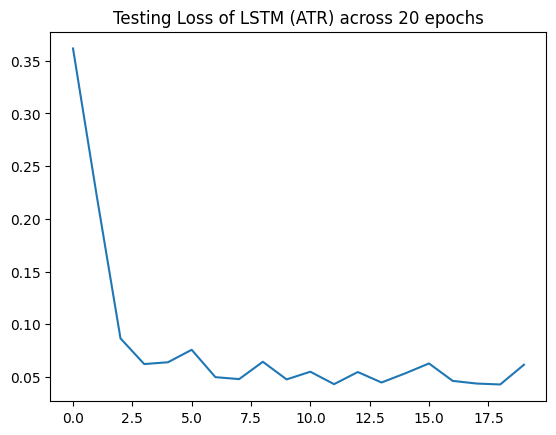

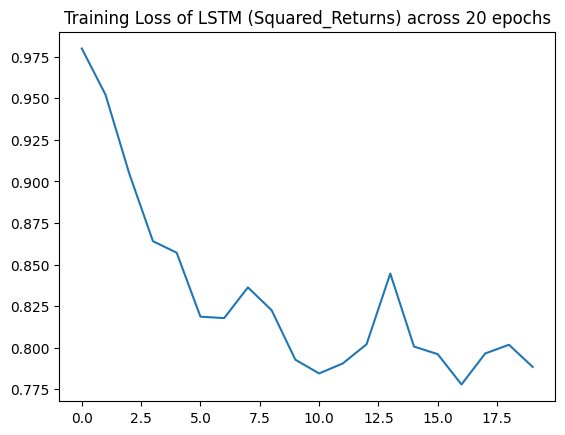

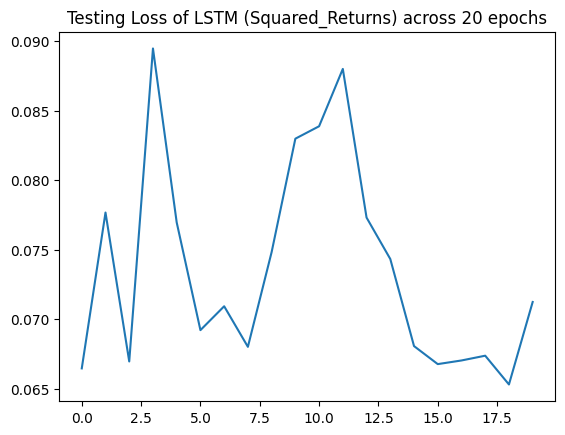

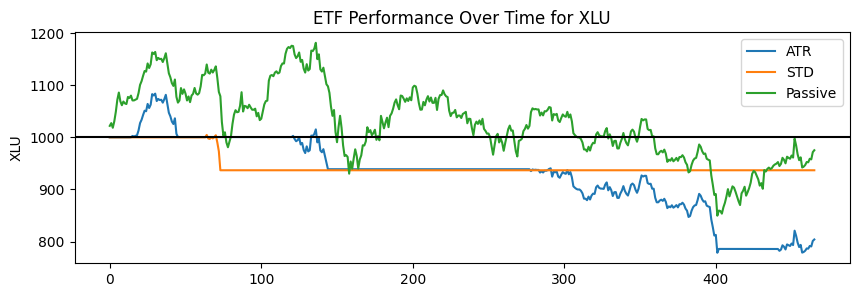

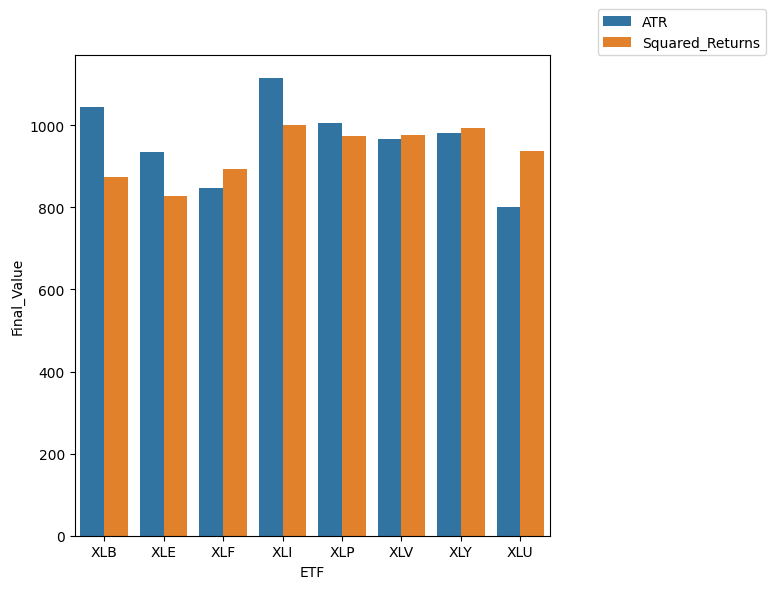

In [5]:
num=10
for file in os.listdir():
    if "runtest" in file:
        num+=1
os.mkdir(f'./runtest_{num}')
with open(f'./runtest_{num}/run_data.txt','w') as f:
    f.write(f'Start Training Date: {start} \n End Training Date: {end} \n Start Sim Date: {start_t} \n End Sim Date: {end_t} \n')
    f.write(f'Model Architecture: \n HL1: {hl1}, HL2: {hl2} \n')
    f.write(f'Look-back window: {T} days')

for etf in etfs:
    os.mkdir(f'./runtest_{num}/{etf}')
for lr in lrs:
    results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[],"Relative_MSE":[]})
    money_df_std = pd.DataFrame()
    money_df_atr = pd.DataFrame()
    money_df_passive = pd.DataFrame()
    for j,etf in enumerate(etfs):
        fig,ax = plt.subplots(1,len(metrics),figsize=(26,6))
        for i,metric in enumerate(metrics):
            scaler = StandardScaler()
            df = get_cleaned_df(etf,start,end)
            #print(df)
            model,fig_tr,fig_te = get_trained_model(df,scaler,metric=metric)
            fig_tr.savefig(f'./runtest_{num}/{etf}/training_results_{metric}')
            fig_te.savefig(f'./runtest_{num}/{etf}/testing_results_{metric}')
            df_test = get_cleaned_df(etf,start_t,end_t)
            ini_cash = 10000
            final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money = backtest_strategy(df_test,model,scaler,metric,sell_scale=1,buy_scale=1)
            print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
            
            if metric=="ATR":
               money_df_atr[etf] = t_money
            elif metric=="Squared_Returns":
                money_df_std[etf] = t_money
                money_df_passive[f"{etf}_{metric}_Passive"] = p_money

            real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
            null_model_error = np.sum((real_met-real_met.mean())**2)
            error = np.sum((real_met-preds)**2)/null_model_error

            results.loc[len(results)] = [etf,metric,final_value,passive_value,error]

            sns.lineplot(preds,ax=ax[i],label=f"Prediction {metric}",color="Blue")
            sns.lineplot(real_met,ax=ax[i],label = f"True {metric}",color="Orange")
            for buy in buy_points:
                ax[i].axvline(buy,color="Green")
            for sell in sell_points:
                ax[i].axvline(sell,color="Red")
            ax[i].set_title(f"{etf} - {metric} | Total Error {error:.2f}")
            #plt.title(f"Performance of LSTM on {etf}")
            fig.savefig(f'./runtest_{num}/{etf}/predictions_lr_{lr}.png')
        
        fig_sim,ax_sim = plt.subplots(figsize=(10,3))
        sns.lineplot(x=range(0, len(df_test.index)-(T+1)), y=money_df_atr[etf], label="ATR",ax=ax_sim)
        sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_std[etf],label="STD",ax=ax_sim)
        sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_passive[f"{etf}_{metric}_Passive"],label="Passive",ax=ax_sim)
        ax_sim.axhline(1000, label = "Initial",color="Black")
        ax_sim.set_title(f"ETF Performance Over Time for {etf}")
        fig_sim.savefig(f"./runtest_{num}/{etf}/simulation_perf_lr_{lr}")
    fig2,ax2 = plt.subplots(figsize = (8,6))
    sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax2)    
    plt.legend(loc=(1.1,1))
    fig2.tight_layout()
    fig2.savefig(f'./runtest_{num}/return_metrics_lr_{lr}.png')
    results.to_csv(f'./runtest_{num}/overall_results.csv',index=False)

In [15]:
os.listdir()

['get_stock_data.ipynb',
 'predictions_lr_0.05.png',
 'predictions_lr_0.png',
 'sim.ipynb',
 'predictions_lr_0.01.png',
 'read_stock_data_from_file.py',
 'testing.ipynb',
 'predictions_lr_0.125.png',
 '__pycache__',
 'full_sim_tests.ipynb',
 'predictions.png',
 'all_etfs_sim.png',
 'predictions_lr_0.5.png',
 'Clean_Data.csv',
 'utils.py',
 'predictions_lr_0.0.png',
 'TSLA.csv',
 'predictions_lr_0.1.png',
 'SPY.csv',
 'planning.txt',
 'return_metrics.png',
 'predictions_lr_0.25.png',
 'predictions_lr_0.375.png',
 'read_and_save_stock_data.py']

In [10]:
results

,ETF,Metric,Final_Value,Passive_Potential
0,XLB,ATR,10002.12,10304.736262
1,XLE,ATR,9158.60,9974.065779
2,XLF,ATR,9105.51,10444.567936
3,XLI,ATR,9086.14,10963.356974
4,XLP,ATR,10118.27,9878.182316
5,XLV,ATR,9988.73,10776.255708
6,XLY,ATR,12520.07,11846.174995
7,XLU,ATR,8284.71,9604.123095
8,XLB,SD_Log_Close,9258.61,10304.736262
9,XLE,SD_Log_Close,10000.00,9974.065779


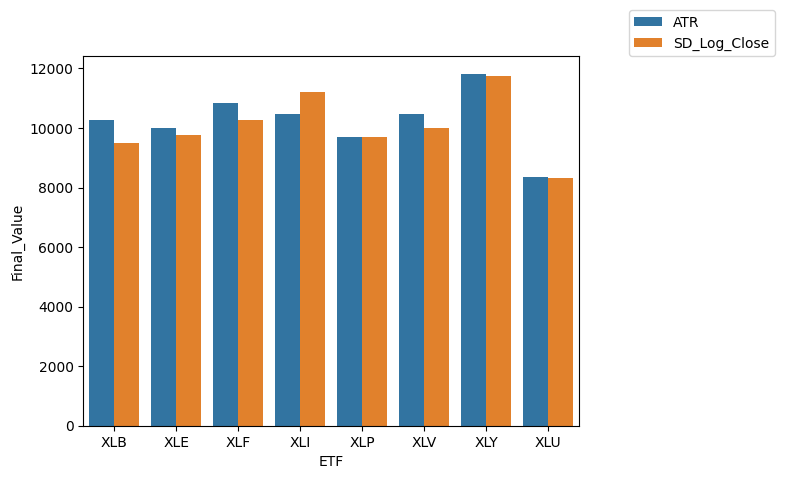

In [6]:
fig2,ax = plt.subplots()
sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax)
plt.legend(loc=(1.1,1))
fig2.savefig('return_metrics.png')


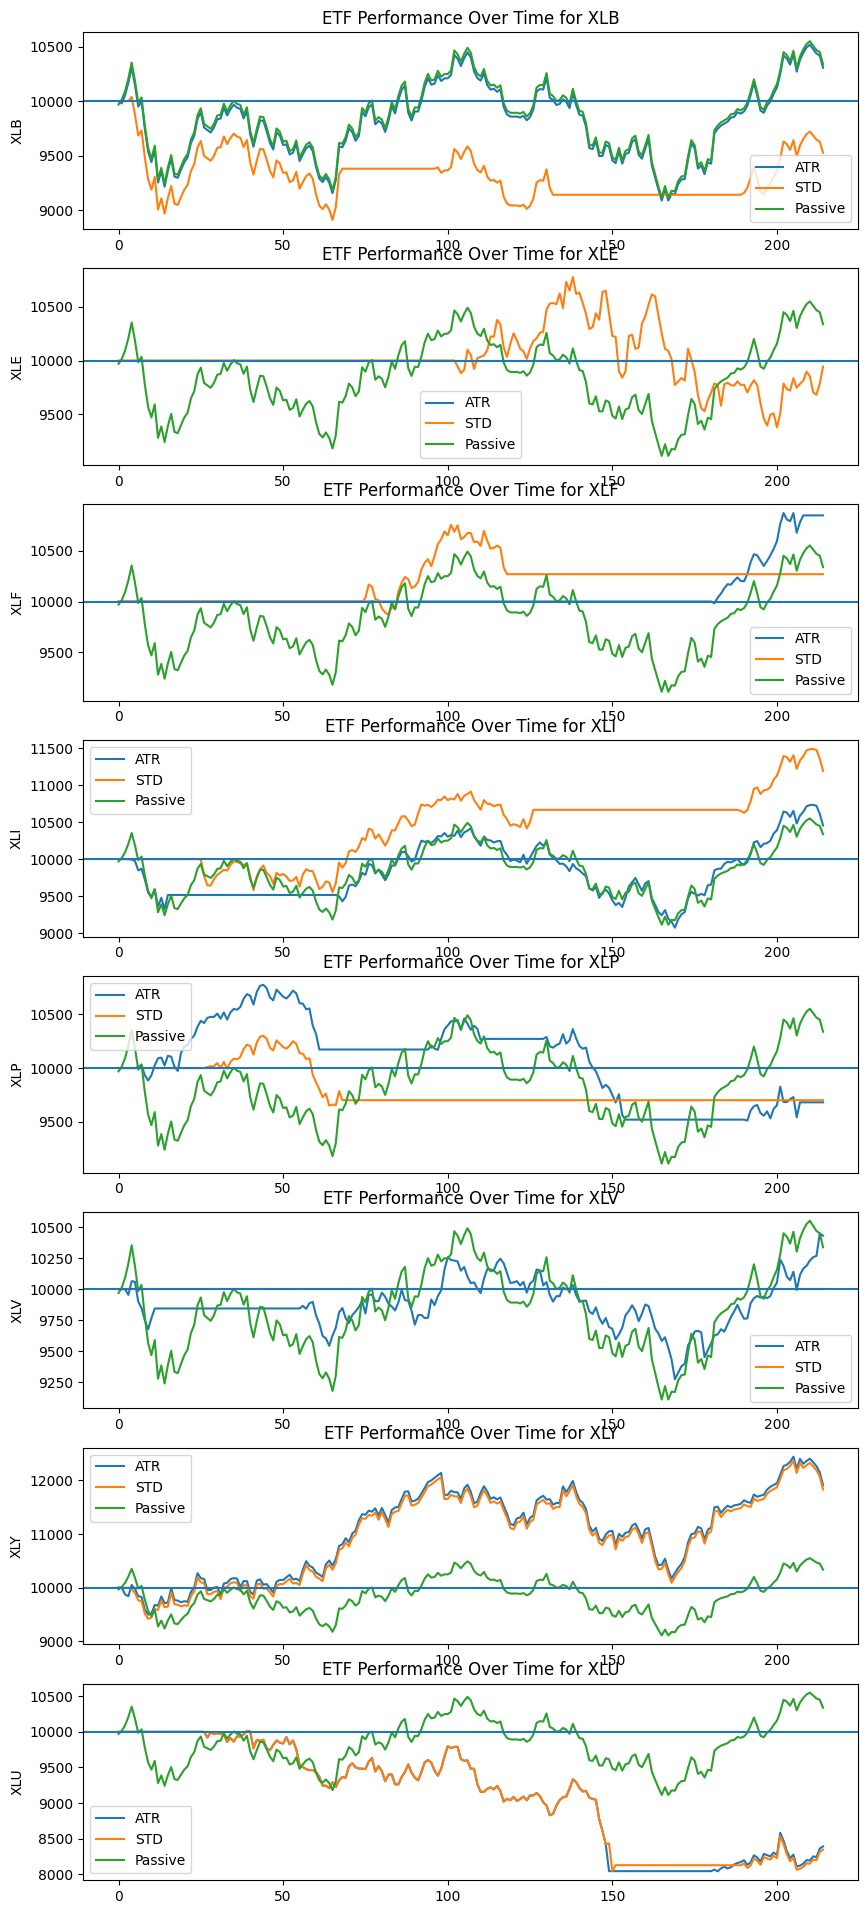

In [14]:
fig3,ax = plt.subplots(len(etfs),1,figsize=(10,24))


for i,etf in enumerate(money_df_atr.columns):
    sns.lineplot(x=range(0, 215), y=money_df_atr[etf], label="ATR", ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_std[etf],label="STD",ax=ax[i])
    sns.lineplot(x=range(0,215),y=money_df_passive[f"XLB_SD_Log_Close_Passive"],label="Passive",ax=ax[i])
    ax[i].axhline(10000)
    ax[i].set_title(f"ETF Performance Over Time for {etf}")
plt.legend()  
plt.show()
      




In [8]:
overall_results = pd.read_csv('./runtest_20/overall_results.csv')
overall_results

,ETF,Metric,Final_Value,Passive_Potential,Relative_MSE
0,XLB,ATR,1044.552951,1030.095425,1.035830
1,XLB,Squared_Returns,874.174985,1030.095425,1.061955
2,XLE,ATR,935.675283,1257.954208,0.088680
3,XLE,Squared_Returns,827.539928,1257.954208,0.953019
4,XLF,ATR,847.015115,985.837923,0.076009
5,XLF,Squared_Returns,892.929993,985.837923,1.025737
6,XLI,ATR,1115.121934,1146.831530,1.152564
7,XLI,Squared_Returns,1000.000000,1146.831530,1.021567
8,XLP,ATR,1005.840859,975.665810,0.371718
9,XLP,Squared_Returns,975.084998,975.665810,0.996702
